In [5]:
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100)
warnings.filterwarnings("ignore")

In [6]:
order = pd.read_csv('/Users/zhangqihao/Desktop/BIA667/JD/JD_ORDER.csv', engine="python")
order.drop('Unnamed: 0',axis=1, inplace=True)
#order = pd.read_csv('/content/drive/MyDrive/BIA667 FINAL/JD_order_data.csv', engine="python")
order = order[['order_ID', 'user_ID', 'sku_ID', 'quantity']]
order.head()

,order_ID,user_ID,sku_ID,quantity
0,d0cf5cc6db,0abe9ef2ce,581d5b54c1,1.0
1,9d74489696,0abe9ef2ce,38d636d2a6,1.0
2,9d74489696,0abe9ef2ce,6717b7c979,1.0
3,e0f5386d87,0b07cae293,589c2b865b,1.0
4,252f6bbde1,010dc4d911,4fe57b6fb2,1.0


In [7]:
user = pd.read_csv('/Users/zhangqihao/Desktop/BIA667/JD/JD_USER.csv', engine="python")
user.drop('Unnamed: 0',axis=1, inplace=True)
user.head()

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power
0,000089d6a6,1,2017-08,0,F,26-35,S,3,4,3
1,0000bc018b,3,2016-06,0,F,>=56,M,3,2,3
2,0000d0e5ab,3,2014-06,0,M,26-35,M,3,2,2
3,0000f81d1b,1,2018-02,0,F,26-35,M,2,3,2
4,00012bb423,4,2008-11,1,F,26-35,M,4,1,2


In [8]:
merged = user.merge(order, how = 'inner', on = 'user_ID')
dp = merged.drop_duplicates(subset = ['order_ID'])

In [9]:
minmaxscaler = MinMaxScaler()

def intable(num):
    return int(num, 16)

dp['quantity'] = minmaxscaler.fit_transform(dp[['quantity']])
dp['user_ID'] = dp['user_ID'].map(intable)
dp['sku_ID'] = dp['sku_ID'].map(intable)
dp = dp.reset_index(drop = True)
dp.head(5)

,user_ID,user_level,first_order_month,plus,gender,age,marital_status,education,city_level,purchase_power,order_ID,sku_ID,quantity
0,9033382,1,2017-08,0,F,26-35,S,3,4,3,6fb419a6de,1003390226737,0.0
1,12321163,3,2016-06,0,F,>=56,M,3,2,3,ebbf0f8a69,1075926493130,0.0
2,13690283,3,2014-06,0,M,26-35,M,3,2,2,e8081938a6,159514644989,0.0
3,16260379,1,2018-02,0,F,26-35,M,2,3,2,65b40d776d,1021740484748,0.0
4,19641379,4,2008-11,1,F,26-35,M,4,1,2,3b768a1d2f,694458610788,0.0


In [10]:
num_user = int(dp.user_ID.nunique())
num_prod = int(dp.sku_ID.nunique())

print('Number of user:', num_user)
print('Number of product:', num_prod)

Number of user: 49712
Number of product: 3535


In [11]:
users = dp.user_ID.unique()
prods = dp.sku_ID.unique()

for i, user in enumerate(users):
    dp.loc[dp['user_ID'] == user, 'user_ID'] = i
    
for i, prod in enumerate(prods):
    dp.loc[dp['sku_ID'] == prod, 'sku_ID'] = i

In [12]:
dp_order = dp[['order_ID', 'user_ID', 'sku_ID', 'quantity']]
dp_user = dp[['user_ID', 'user_level', 'gender', 'age', 'education', 'city_level']]

In [13]:
dp_order.user_ID =dp_order.user_ID.astype('category').cat.codes.values
dp_order.sku_ID = dp_order.sku_ID.astype('category').cat.codes.values

dp_order.head(5)

,order_ID,user_ID,sku_ID,quantity
0,6fb419a6de,0,0,0.0
1,ebbf0f8a69,1,1,0.0
2,e8081938a6,2,2,0.0
3,65b40d776d,3,3,0.0
4,3b768a1d2f,4,4,0.0


In [14]:
train, test = train_test_split(dp_order, test_size=0.2)

In [15]:
from keras.layers import Input, Dense, Embedding, Flatten, Dropout
from keras import regularizers
from keras.layers import concatenate
from keras.models import Model
from keras.layers.merge import multiply
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error

## MODEL 1

Basic & Simple Linear Model

In [16]:
prod_inputs = Input(shape=(1,), dtype='int32')
p = Embedding(num_prod + 1, 100, name="movie")(prod_inputs)

user_inputs = Input(shape=(1,), dtype='int32')
u = Embedding(num_user + 1, 100, name="user")(user_inputs)

o = multiply([p, u])
o = Dropout(0.2)(o)
o = Flatten()(o)
o = Dense(1)(o)

rec_model = Model(inputs=[prod_inputs, user_inputs], outputs=o)
rec_model.compile(loss='mae', optimizer='adam', metrics=["mae"])

model1_history = rec_model.fit([dp_order.sku_ID, dp_order.user_ID], dp_order.quantity, 
                               epochs=10, verbose=2, validation_split=0.1)

Epoch 1/10
1488/1488 - 47s - loss: 0.0017 - mae: 0.0017 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 2/10
1488/1488 - 45s - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 3/10
1488/1488 - 45s - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 4/10
1488/1488 - 45s - loss: 0.0015 - mae: 0.0015 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 5/10
1488/1488 - 45s - loss: 0.0015 - mae: 0.0015 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 6/10
1488/1488 - 46s - loss: 0.0014 - mae: 0.0014 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 7/10
1488/1488 - 46s - loss: 0.0013 - mae: 0.0013 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 8/10
1488/1488 - 47s - loss: 0.0012 - mae: 0.0012 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 9/10
1488/1488 - 45s - loss: 0.0012 - mae: 0.0012 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 10/10
1488/1488 - 41s - loss: 0.0011 - mae: 0.0011 - val_loss: 0.0014 - val_mae: 0.0014


## MODEL 2

Basic Model Introduced Bias

In [17]:
bias = 1

prod_inputs = Input(shape=(1,), dtype='int32')
prod = Embedding(num_prod + 1, 100, name="movie")(prod_inputs)
prod_bias = Embedding(num_prod + 1, bias, name="moviebias")(prod_inputs)

user_inputs = Input(shape=(1,), dtype='int32')
user = Embedding(num_user + 1, 100, name="user")(user_inputs)
user_bias = Embedding(num_user + 1, bias, name="userbias")(user_inputs)

o = multiply([prod, user])
o = concatenate([o, prod_bias, user_bias])
o = Dropout(0.5)(o)
o = Flatten()(o)
o = Dense(1)(o)

rec_model = Model(inputs=[prod_inputs, user_inputs], outputs=o)
rec_model.compile(loss='mae', optimizer='adam', metrics=["mae"])

model2_history = rec_model.fit([dp_order.sku_ID, dp_order.user_ID], dp_order.quantity,
                               epochs=10, verbose=2, validation_split=0.1)

Epoch 1/10
1488/1488 - 39s - loss: 0.0020 - mae: 0.0020 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 2/10
1488/1488 - 41s - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 3/10
1488/1488 - 40s - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0015 - val_mae: 0.0015
Epoch 4/10
1488/1488 - 40s - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 5/10
1488/1488 - 42s - loss: 0.0016 - mae: 0.0016 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 6/10
1488/1488 - 40s - loss: 0.0015 - mae: 0.0015 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 7/10
1488/1488 - 41s - loss: 0.0015 - mae: 0.0015 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 8/10
1488/1488 - 40s - loss: 0.0014 - mae: 0.0014 - val_loss: 0.0013 - val_mae: 0.0013
Epoch 9/10
1488/1488 - 40s - loss: 0.0014 - mae: 0.0014 - val_loss: 0.0014 - val_mae: 0.0014
Epoch 10/10
1488/1488 - 40s - loss: 0.0013 - mae: 0.0013 - val_loss: 0.0015 - val_mae: 0.0015


## MODEL 3

Neural Collaborative Filtering 

In [18]:
mf_dim = 10
layers = [128, 64, 32, 16, 8]


user_input = Input(shape=(1,), dtype='int32')
prod_input = Input(shape=(1,), dtype='int32')


MF_Embedding_User = Embedding(input_dim = num_user + 1, output_dim = mf_dim, input_length=1)
MF_Embedding_Prod = Embedding(input_dim = num_prod + 1, output_dim = mf_dim, input_length=1)


MLP_Embedding_User = Embedding(input_dim = num_user + 1, output_dim = int(layers[0]/2), input_length=1)
MLP_Embedding_Prod = Embedding(input_dim = num_prod + 1, output_dim = int(layers[0]/2), input_length=1)


mf_user_latent = Flatten()(MF_Embedding_User(user_input))
mf_prod_latent = Flatten()(MF_Embedding_Prod(prod_input))
mf_vector = concatenate([mf_user_latent, mf_prod_latent])


mlp_user_latent = Flatten()(MLP_Embedding_User(user_input)) 
mlp_prod_latent = Flatten()(MLP_Embedding_Prod(prod_input))
mlp_vector = concatenate([mlp_user_latent, mlp_prod_latent])

for idx in range(1, len(layers)):
    layer = Dense(layers[idx], activation='relu', name="layer%d" %idx)
    mlp_vector = layer(mlp_vector)
    
predict_vector = concatenate([mf_vector, mlp_vector])
prediction = Dense(1, activation='sigmoid', 
                   kernel_initializer='lecun_uniform', kernel_regularizer=regularizers.l2(0.01))(predict_vector)

model = Model(inputs = [user_input, prod_input], outputs = prediction)
model.compile(optimizer = Adam(lr=0.001), loss = 'binary_crossentropy', metrics=['mae'])   

In [19]:
model3_history = model.fit([train.user_ID, train.sku_ID], train.quantity, 
                             epochs=10, verbose=2, validation_split=0.1)

Epoch 1/10
1190/1190 - 21s - loss: 0.0414 - mae: 0.0241 - val_loss: 0.0117 - val_mae: 0.0023
Epoch 2/10
1190/1190 - 21s - loss: 0.0097 - mae: 0.0014 - val_loss: 0.0109 - val_mae: 0.0023
Epoch 3/10
1190/1190 - 21s - loss: 0.0084 - mae: 0.0011 - val_loss: 0.0108 - val_mae: 0.0029
Epoch 4/10
1190/1190 - 23s - loss: 0.0077 - mae: 7.1099e-04 - val_loss: 0.0108 - val_mae: 0.0029
Epoch 5/10
1190/1190 - 24s - loss: 0.0075 - mae: 5.9395e-04 - val_loss: 0.0113 - val_mae: 0.0035
Epoch 6/10
1190/1190 - 24s - loss: 0.0075 - mae: 5.3649e-04 - val_loss: 0.0113 - val_mae: 0.0035
Epoch 7/10
1190/1190 - 27s - loss: 0.0074 - mae: 5.0620e-04 - val_loss: 0.0117 - val_mae: 0.0040
Epoch 8/10
1190/1190 - 24s - loss: 0.0074 - mae: 4.6700e-04 - val_loss: 0.0120 - val_mae: 0.0042
Epoch 9/10
1190/1190 - 25s - loss: 0.0074 - mae: 4.3815e-04 - val_loss: 0.0136 - val_mae: 0.0061
Epoch 10/10
1190/1190 - 24s - loss: 0.0073 - mae: 4.0474e-04 - val_loss: 0.0118 - val_mae: 0.0040


## Visualization

In [20]:
import matplotlib.pyplot as plt

def smooth_curve(points, factor=0.5):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

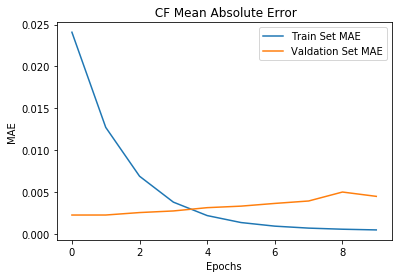

In [21]:
# Collaborative Filtering Results

plt.plot(smooth_curve(model3_history.history['mae']), label='Train Set MAE')
plt.plot(smooth_curve(model3_history.history['val_mae']), label='Valdation Set MAE')
plt.title(' CF Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

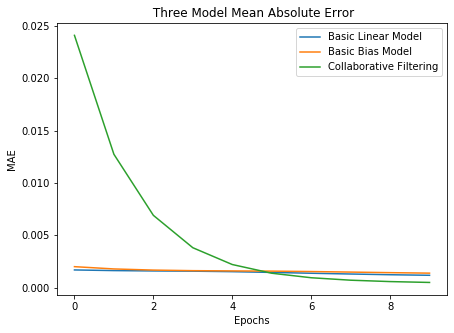

In [22]:
# Three model comparsion

plt.figure(figsize=(7,5))
plt.plot(smooth_curve(model1_history.history['mae']), label='Basic Linear Model')
plt.plot(smooth_curve(model2_history.history['mae']), label='Basic Bias Model')
plt.plot(smooth_curve(model3_history.history['mae']), label='Collaborative Filtering')
plt.title(' Three Model Mean Absolute Error')
plt.xlabel('Epochs')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Model Prediction

In [23]:
result = model.predict([test.user_ID, test.sku_ID])
test['Rank_Score'] = result 
test.head()

,order_ID,user_ID,sku_ID,quantity,Rank_Score
22758,3c00812077,21397,153,0.000000,0.010535
35734,7ce762a914,33605,1109,0.000000,0.004954
6222,c5fe7874fe,5860,317,0.000000,0.006170
40739,09f6e2df53,38284,56,0.000000,0.002030
34603,0a666f5099,32545,106,0.006711,0.006308


In [24]:
dp_user.loc[dp_user['gender'] == 'F', 'gender'] = 1
dp_user.loc[dp_user['gender'] == 'M', 'gender'] = 1
dp_user.loc[dp_user['age'] == '<=15', 'age'] = 1
dp_user.loc[dp_user['age'] == '16-25', 'age'] = 2
dp_user.loc[dp_user['age'] == '26-35', 'age'] = 3
dp_user.loc[dp_user['age'] == '36-45', 'age'] = 4
dp_user.loc[dp_user['age'] == '46-55', 'age'] = 5
dp_user.loc[dp_user['age'] == '>=56', 'age'] = 6
dp_user.head(5)

,user_ID,user_level,gender,age,education,city_level
0,0,1,1,3,3,4
1,1,3,1,6,3,2
2,2,3,1,3,3,2
3,3,1,1,3,2,3
4,4,4,1,3,4,1


## Calculate User Cluster by K means 

In [25]:
user_train = dp_user[['user_level', 'gender', 'age', 'education', 'city_level']]
transfer = preprocessing.MinMaxScaler()
user_train = transfer.fit_transform(user_train)
estimator = KMeans(n_clusters=10)
estimator.fit(user_train)

KMeans(n_clusters=10)

In [26]:
user_predict = estimator.predict(user_train)
result = pd.concat((dp_user,pd.DataFrame(user_predict)),axis=1)
result.rename({0:u'User_Cluster'},axis=1,inplace=True)

In [32]:
result.head(10)

,user_ID,user_level,gender,age,education,city_level,User_Cluster
0,0,1,1,3,3,4,5
1,1,3,1,6,3,2,6
2,2,3,1,3,3,2,0
3,3,1,1,3,2,3,3
4,4,4,1,3,4,1,0
5,5,3,1,3,3,4,5
6,6,4,1,4,3,4,2
7,7,2,1,2,3,2,7
8,8,4,1,4,4,2,6
9,9,3,1,6,3,3,2


## Calculate Product Recommendation  Rank by Customer Cluster

In [33]:
final_result = test.merge(result, how = 'left', on = 'user_ID')
final_result = final_result.drop_duplicates(subset = ['order_ID'])
final_result.head(10)

,order_ID,user_ID,sku_ID,quantity,Rank_Score,user_level,gender,age,education,city_level,User_Cluster
0,3c00812077,21397,153,0.000000,0.010535,4,1,3,3,1,0
1,7ce762a914,33605,1109,0.000000,0.004954,4,1,3,3,4,5
2,c5fe7874fe,5860,317,0.000000,0.006170,1,1,4,-1,3,1
3,09f6e2df53,38284,56,0.000000,0.002030,4,1,3,4,2,0
4,0a666f5099,32545,106,0.006711,0.006308,1,1,2,-1,1,8
5,cca29549f6,18068,72,0.000000,0.001067,1,1,4,2,4,2
6,3b2575e18f,3450,396,0.000000,0.003509,1,1,2,3,3,5
7,9d2eb6ce32,47452,23,0.000000,0.001645,4,1,4,4,4,2
8,21946c2240,14345,14,0.000000,0.006884,3,1,6,3,1,6
9,f7f4ea97b4,36983,152,0.000000,0.005356,4,1,4,4,2,6


In [28]:
# Select Top k by User_Cluster

k = 10

Rank = final_result.groupby("User_Cluster", as_index=False).apply(lambda final_result : final_result.drop_duplicates("sku_ID"))
Rank = Rank.groupby('User_Cluster', group_keys=False).\
       apply(lambda x: x.sort_values('Rank_Score', ascending=False)).groupby('User_Cluster').head(k).reset_index()
Rank = Rank[['sku_ID', 'Rank_Score', 'User_Cluster']]

In [29]:
# Product Recommendation Rank Table

ProductRec = pd.DataFrame(index = Rank.groupby('User_Cluster').sum().index,
                    columns=['TOP {}'.format(i) for i in range(1, 11)])
for i in range(10):
  for j in range(10):
    ProductRec.iloc[i,j] = Rank.sku_ID.values[i*10+j]

ProductRec

,TOP 1,TOP 2,TOP 3,TOP 4,TOP 5,TOP 6,TOP 7,TOP 8,TOP 9,TOP 10
User_Cluster,,,,,,,,,,
0,2069,182,646,3322,1230,3321,948,118,441,234
1,284,1629,1836,2207,315,2751,343,2010,3272,2576
2,9,275,71,93,2629,385,3196,3006,1736,892
3,441,3088,116,118,482,2902,153,1000,3139,1548
4,60,171,296,441,589,1661,2022,1975,44,3021
5,118,665,2207,153,1134,1437,1724,1661,1511,3383
6,2584,646,275,837,241,1317,118,153,116,1975
7,646,12,643,241,93,44,3000,2796,2347,2992
8,60,171,153,441,3012,182,2600,2736,2072,1323


In [30]:
# Product Recommendation Rank Visualization Chart

Rank.style.bar(color = 'lightcoral', subset=['Rank_Score'])

,sku_ID,Rank_Score,User_Cluster
0,2069,0.051210,0
1,182,0.035047,0
2,646,0.035036,0
3,3322,0.031826,0
4,1230,0.024326,0
5,3321,0.016005,0
6,948,0.015789,0
7,118,0.014836,0
8,441,0.013592,0
9,234,0.013535,0
